# Installation and Importing Libraries


In [ ]:
!pip install -U -q pdfplumber tiktoken openai chromaDB sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Read, Process, and Chunk the PDF Files

In [ ]:
single_pdf_path= "/content/drive/My Drive/HelpMateAI/Policy Documents/HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf"


## 2.1 Reading a single PDF file and exploring it through pdfplumber

In [ ]:
with pdfplumber.open(single_pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[5]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

iii. A rise in cardiac biomarkers or Troponin T or I in absence of overtischemic heart
disease OR following an intra-arterial cardiac procedure.
Kidney End stage renal disease presenting as chronic irreversible failure of both kidneys to
Failure function, as a result of which either regular renal dialysis (hemodialysis or peritoneal
3 requiring dialysis) is instituted or renal transplantation is carried out. Diagnosis has to be
regular confirmed by a specialist Medical Practitioner.
dialysis
Any cerebrovascular incident producing permanent neurological sequelae. This
includes infarction of brain tissue, thrombosis in an intracranial vessel, haemorrhage
and embolisation from an extracranial source. Diagnosis has to be confirmed by a
Stroke specialist Medical Practitioner and evidenced by typical clinical symptoms as well as
resulting typical findings in CT Scan or MRI of the brain. Evidence of permanent neurological
4 in deficit lasting for at least 3 months has to be produced.
permanen

In [ ]:
# View the table in the page, if any

tables[0]

[['',
  '',
  'iii. A rise in cardiac biomarkers or Troponin T or I in absence of overtischemic heart\ndisease OR following an intra-arterial cardiac procedure.'],
 ['3',
  'Kidney\nFailure\nrequiring\nregular\ndialysis',
  'End stage renal disease presenting as chronic irreversible failure of both kidneys to\nfunction, as a result of which either regular renal dialysis (hemodialysis or peritoneal\ndialysis) is instituted or renal transplantation is carried out. Diagnosis has to be\nconfirmed by a specialist Medical Practitioner.'],
 ['4',
  'Stroke\nresulting\nin\npermanent\nsymptoms',
  'Any cerebrovascular incident producing permanent neurological sequelae. This\nincludes infarction of brain tissue, thrombosis in an intracranial vessel, haemorrhage\nand embolisation from an extracranial source. Diagnosis has to be confirmed by a\nspecialist Medical Practitioner and evidenced by typical clinical symptoms as well as\ntypical findings in CT Scan or MRI of the brain. Evidence of permane

## 2.2 Extracting Text

In [ ]:
pdf_path="/content/drive/My Drive/HelpMateAI/Policy Documents"

In [ ]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

Function to extract text from a PDF file.
1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
2. Declare an empty list 'full_text' to store all the text files
3. Use pdfplumber to open the pdf pages one by one
4. Find the tables and their locations in the page
5. Extract the text from the tables in the variable 'tables'
6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
8. Declare an empty list 'lines' to store the page text
9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
10. Append the page number and all lines to full_text, and increment 'p'
11. When the function has iterated over all pages, return the 'full_text' list


In [ ]:
def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

In [ ]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing HDFC-Life-Group-Term-Life-Policy.pdf
Finished processing HDFC-Life-Group-Term-Life-Policy.pdf
...Processing HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf
Finished processing HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf
...Processing  HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf
Finished processing  HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf
...Processing HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf
Finished processing HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf
...Processing HDFC-Surgicare-Plan-101N043V01.pdf
Finished processing HDFC-Surgicare-Plan-101N043V01.pdf
...Processing HDFC-Life-Smart-Pension-Plan-Policy-Document-Online.pdf
Finished processing HDFC-Life-Smart-Pension-Plan-Policy-Document-Online.pdf
...Processing HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf
Finished processing HDFC-Life-Group-Poorna-Suraksha-101N137V0

In [ ]:
# Concatenate all the PDFs in the list 'data' together

insurance_pdfs_data = pd.concat(data, ignore_index=True)
insurance_pdfs_data

,Page No.,Page_Text,Document Name
0,Page 1,HDFC Life Group Term Life OF «OWNERNAME» Based...,HDFC-Life-Group-Term-Life-Policy.pdf
1,Page 2,PART A: Covering Letter with Policy Schedule <...,HDFC-Life-Group-Term-Life-Policy.pdf
2,Page 3,Address : Mobile/Landline Number : A1 Free Loo...,HDFC-Life-Group-Term-Life-Policy.pdf
3,Page 4,"[[""Name of Policy"", ""HDFC Life Group Term Life...",HDFC-Life-Group-Term-Life-Policy.pdf
4,Page 5,"[[""Policy No."", """"], [""Name & Address of Polic...",HDFC-Life-Group-Term-Life-Policy.pdf
...,...,...,...
212,Page 27,Annexure IV Definitions of covered Critical Il...,HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...
213,Page 28,6. Alzheimer's Disease - Deterioration or loss...,HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...
214,Page 29,13. Third Degree Burns - There must be third-d...,HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...
215,Page 30," One of the following human organs: heart, lu...",HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...


In [ ]:
# Check one of the extracted page texts to ensure that the text has been correctly read

insurance_pdfs_data.Page_Text[2]

'Address : Mobile/Landline Number : A1 Free Look Provisions: For the Master Policyholder The Master Policyholder shall have a period of 15 days from the date of receipt of the Master Policy document to review the terms and conditions of this Policy and if the Master Policyholder disagrees with any of the terms and conditions, he/she has the option to return the Master Policy stating the reasons for the cancellation upon which the Company shall refund the Premium paid subject to deduction of a proportionate risk Premium for the period of Insurance Cover in addition to the expenses incurred on medical examination (if any) and the stamp duty charges. All Benefits and rights under this Policy shall immediately stand terminated on the cancellation of the Policy. The Master Policyholder shall have a period of 30 days if the Policy is sourced through Direct Sales# from the date of receipt of the Master Policy document to review the terms and conditions of this Policy and if the Master Policyh

In [ ]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))
insurance_pdfs_data['Text_Length']

0       57
1      400
2      618
3       67
4      174
      ... 
212    582
213    625
214    642
215    586
216    301
Name: Text_Length, Length: 217, dtype: int64

In [ ]:
# Retain only the rows with a text length of at least 10

insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,HDFC Life Group Term Life OF «OWNERNAME» Based...,HDFC-Life-Group-Term-Life-Policy.pdf,57
1,Page 2,PART A: Covering Letter with Policy Schedule <...,HDFC-Life-Group-Term-Life-Policy.pdf,400
2,Page 3,Address : Mobile/Landline Number : A1 Free Loo...,HDFC-Life-Group-Term-Life-Policy.pdf,618
3,Page 4,"[[""Name of Policy"", ""HDFC Life Group Term Life...",HDFC-Life-Group-Term-Life-Policy.pdf,67
4,Page 5,"[[""Policy No."", """"], [""Name & Address of Polic...",HDFC-Life-Group-Term-Life-Policy.pdf,174
...,...,...,...,...
212,Page 27,Annexure IV Definitions of covered Critical Il...,HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...,582
213,Page 28,6. Alzheimer's Disease - Deterioration or loss...,HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...,625
214,Page 29,13. Third Degree Burns - There must be third-d...,HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...,642
215,Page 30," One of the following human organs: heart, lu...",HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...,586


In [ ]:
# Store the metadata for each page in a separate column

insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

<ipython-input-16-4493f15e2dc4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)


In [ ]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,HDFC Life Group Term Life OF «OWNERNAME» Based...,HDFC-Life-Group-Term-Life-Policy.pdf,57,{'Policy_Name': 'HDFC-Life-Group-Term-Life-Pol...
1,Page 2,PART A: Covering Letter with Policy Schedule <...,HDFC-Life-Group-Term-Life-Policy.pdf,400,{'Policy_Name': 'HDFC-Life-Group-Term-Life-Pol...
2,Page 3,Address : Mobile/Landline Number : A1 Free Loo...,HDFC-Life-Group-Term-Life-Policy.pdf,618,{'Policy_Name': 'HDFC-Life-Group-Term-Life-Pol...
3,Page 4,"[[""Name of Policy"", ""HDFC Life Group Term Life...",HDFC-Life-Group-Term-Life-Policy.pdf,67,{'Policy_Name': 'HDFC-Life-Group-Term-Life-Pol...
4,Page 5,"[[""Policy No."", """"], [""Name & Address of Polic...",HDFC-Life-Group-Term-Life-Policy.pdf,174,{'Policy_Name': 'HDFC-Life-Group-Term-Life-Pol...
...,...,...,...,...,...
212,Page 27,Annexure IV Definitions of covered Critical Il...,HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...,582,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...
213,Page 28,6. Alzheimer's Disease - Deterioration or loss...,HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...,625,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...
214,Page 29,13. Third Degree Burns - There must be third-d...,HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...,642,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...
215,Page 30," One of the following human organs: heart, lu...",HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...,586,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...


####This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:
1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.

# Generate and Store Embeddings using OpenAI and ChromaDB
####In this section, we will embed the pages in the dataframe through OpenAI's text-embedding-ada-002 model, and store them in a ChromaDB collection.

In [ ]:
openai.api_key ="sk-proj-7NR8hPmh2aYvAGhpXuzuT3BlbkFJhHRntDaFQ5h4INLbzkDidv"

In [ ]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [ ]:
# Define the path where chroma collections will be stored

chroma_data_path = '/content/drive/My Drive/HelpMateAI/ChromaDB_Data'

In [ ]:
import chromadb

In [ ]:
# Call PersistentClient()  to persist the data to disk

client = chromadb.PersistentClient(path=chroma_data_path)

In [ ]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [ ]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=embedding_function)

In [ ]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [ ]:
# insurance_collection.delete(
#     ids = [str(i) for i in range(0, len(documents_list))],

# )


In [ ]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [ ]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': [[-0.0045278058387339115,
   0.0054623824544250965,
   0.014899247325956821,
   -0.043024275451898575,
   -0.02039199508726597,
   0.02207895740866661,
   0.007894981652498245,
   0.004679632373154163,
   -0.02503451332449913,
   -0.005131737794727087,
   0.013914061710238457,
   0.03965035080909729,
   -0.021809043362736702,
   0.008441557176411152,
   -0.0027227564714848995,
   0.016829131171107292,
   0.0161813385784626,
   -0.019190877676010132,
   0.03436003997921944,
   -0.010978748090565205,
   0.015196152962744236,
   0.014966725371778011,
   -0.003220410319045186,
   0.009548204019665718,
   -0.006859187036752701,
   -0.02804405428469181,
   0.019825175404548645,
   0.0026434692554175854,
   -0.007355153560638428,
   -0.00023195725225377828,
   0.0019130147993564606,
   0.009082602337002754,
   -0.0216875821352005,
   -0.01094500906765461,
   -0.0011226731585338712,
   0.011316140182316303,
   -0.004713371396064758,
   -0.022780733183026

In [ ]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [ ]:
cache_collection.peek()

{'ids': ['What are Accidental Death Benefits?',
  'What are accidental benefits',
  'what are the death benefits',
  'what is Beneficiary?'],
 'embeddings': [[-0.007106959354132414,
   0.005682905670255423,
   0.001771748997271061,
   -0.044265445321798325,
   -0.03665274754166603,
   0.020721977576613426,
   -0.030477410182356834,
   0.01672930270433426,
   -0.02014969475567341,
   0.00541340047493577,
   0.025193771347403526,
   0.02380964532494545,
   -0.030716970562934875,
   0.018925273790955544,
   -0.010447496548295021,
   0.015464956872165203,
   0.03713186830282211,
   0.006181989796459675,
   0.015105616301298141,
   -0.006351678632199764,
   -0.006072191521525383,
   0.008411233313381672,
   -0.01583760604262352,
   0.018712330609560013,
   0.003405418014153838,
   0.01672930270433426,
   0.00021117502183187753,
   -0.01957741007208824,
   0.013827960006892681,
   -0.018818803131580353,
   0.01817997545003891,
   -0.017221733927726746,
   -0.015850914642214775,
   -0.0155847

# Semantic Search with Cache
####In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [ ]:
# Read the user query

query = input()

what is Annuitant and what are its plans? 


In [ ]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [ ]:
cache_results

{'ids': [['What is Annuitant and Annuitant Plans']],
 'distances': [[0.07155666883184059]],
 'metadatas': [[{'distances0': '0.35748982429504395',
    'distances1': '0.37340396642684937',
    'distances2': '0.39342355728149414',
    'distances3': '0.40995168685913086',
    'distances4': '0.410061776638031',
    'distances5': '0.4130840599536896',
    'distances6': '0.417866587638855',
    'distances7': '0.4192923307418823',
    'distances8': '0.42213958501815796',
    'distances9': '0.4235905706882477',
    'documents0': 'HDFC Life Smart Pension Plan 101L164V02 – Terms and Conditions (Direct & Online Sales) (A Unit Linked Non-Participating Individual Pension Plan) iii. "An investor, by subscribing or purchasing an interest in the Large Cap - Pension Fund, will be regarded as having acknowledged, understood and accepted the disclaimer referred to in Clauses above and will be bound by it. F. 19. Annuity Plan: F.19.1 As per the prevailing regulations, the Annuitant can purchase annuity fro

In [ ]:
# results = insurance_collection.query(
# query_texts=query,
# n_results=10
# )

In [ ]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()

# If the distance is greater than the threshold, then return the results from the main collection.
if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
    results = insurance_collection.query(
        query_texts=query,
        n_results=10
    )
     # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
    Keys = []
    Values = []

    for key, val in results.items():
        if val is None:
            continue
        print(f"Key: {key}, Value: {val}")  # Debug print
        for i in range(10):
            if len(val[0]) > i:  # Ensure val[0] has enough elements
                print(f"Appending Key: {str(key)+str(i)}, Value: {str(val[0][i])}")  # Debug print
                Keys.append(str(key)+str(i))
                Values.append(str(val[0][i]))
            else:
                print(f"Skipping Key: {str(key)+str(i)} because it is out of range")  # Debug print

    cache_collection.add(
        documents=[query],
        ids=[query],
        metadatas=dict(zip(Keys, Values))
    )

    print("Not found in cache. Found in main collection.")

    result_dict = {
        'Metadatas': results['metadatas'][0],
        'Documents': results['documents'][0],
        'Distances': results['distances'][0],
        'IDs': results['ids'][0]
    }
    results_df = pd.DataFrame.from_dict(result_dict)
    results_df
# If the distance is, however, less than the threshold, you can return the results from cacheS
elif cache_results['distances'][0][0] <= threshold:
    cache_result_dict = cache_results['metadatas'][0][0]

    for key, value in cache_result_dict.items():
        if 'ids' in key:
            ids.append(value)
        elif 'documents' in key:
            documents.append(value)
        elif 'distances' in key:
            distances.append(value)
        elif 'metadatas' in key:
            metadatas.append(value)

    print("Found in cache!")

    results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
    })


Found in cache!


In [ ]:
results_df

,IDs,Documents,Distances,Metadatas
0,24,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.35748982429504395,"{'Page_No.': 'Page 25', 'Policy_Name': 'Copy o..."
1,3,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.37340396642684937,"{'Page_No.': 'Page 4', 'Policy_Name': 'Copy of..."
2,7,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.39342355728149414,"{'Page_No.': 'Page 8', 'Policy_Name': 'Copy of..."
3,88,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,0.40995168685913086,"{'Page_No.': 'Page 6', 'Policy_Name': 'Copy of..."
4,35,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.410061776638031,"{'Page_No.': 'Page 36', 'Policy_Name': 'Copy o..."
5,4,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.4130840599536896,"{'Page_No.': 'Page 5', 'Policy_Name': 'Copy of..."
6,90,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,0.417866587638855,"{'Page_No.': 'Page 8', 'Policy_Name': 'Copy of..."
7,6,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.4192923307418823,"{'Page_No.': 'Page 7', 'Policy_Name': 'Copy of..."
8,36,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.42213958501815796,"{'Page_No.': 'Page 37', 'Policy_Name': 'Copy o..."
9,5,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.4235905706882477,"{'Page_No.': 'Page 6', 'Policy_Name': 'Copy of..."


# Re-ranking and ordering


Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

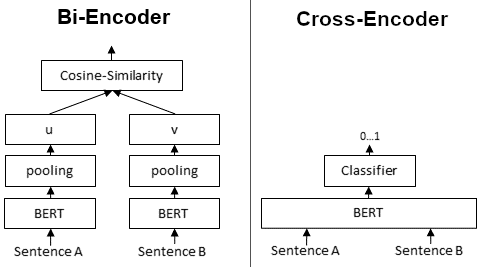

<br>

In [ ]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [ ]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [ ]:
scores

array([  3.8467617, -11.252879 ], dtype=float32)

In [ ]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [ ]:
cross_rerank_scores

array([ -0.02625341,  -4.623171  ,  -4.2246094 , -10.160775  ,
        -7.628626  ,  -8.40389   ,  -8.993599  ,  -7.6716146 ,
        -9.745934  ,  -5.323214  ], dtype=float32)

In [ ]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [ ]:
results_df

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,24,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.35748982429504395,"{'Page_No.': 'Page 25', 'Policy_Name': 'Copy o...",-0.026253
1,3,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.37340396642684937,"{'Page_No.': 'Page 4', 'Policy_Name': 'Copy of...",-4.623171
2,7,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.39342355728149414,"{'Page_No.': 'Page 8', 'Policy_Name': 'Copy of...",-4.224609
3,88,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,0.40995168685913086,"{'Page_No.': 'Page 6', 'Policy_Name': 'Copy of...",-10.160775
4,35,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.410061776638031,"{'Page_No.': 'Page 36', 'Policy_Name': 'Copy o...",-7.628626
5,4,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.4130840599536896,"{'Page_No.': 'Page 5', 'Policy_Name': 'Copy of...",-8.403890
6,90,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,0.417866587638855,"{'Page_No.': 'Page 8', 'Policy_Name': 'Copy of...",-8.993599
7,6,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.4192923307418823,"{'Page_No.': 'Page 7', 'Policy_Name': 'Copy of...",-7.671615
8,36,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.42213958501815796,"{'Page_No.': 'Page 37', 'Policy_Name': 'Copy o...",-9.745934
9,5,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.4235905706882477,"{'Page_No.': 'Page 6', 'Policy_Name': 'Copy of...",-5.323214


In [ ]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,24,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.35748982429504395,"{'Page_No.': 'Page 25', 'Policy_Name': 'Copy o...",-0.026253
1,3,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.37340396642684937,"{'Page_No.': 'Page 4', 'Policy_Name': 'Copy of...",-4.623171
2,7,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.39342355728149414,"{'Page_No.': 'Page 8', 'Policy_Name': 'Copy of...",-4.224609


In [ ]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,24,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.35748982429504395,"{'Page_No.': 'Page 25', 'Policy_Name': 'Copy o...",-0.026253
2,7,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.39342355728149414,"{'Page_No.': 'Page 8', 'Policy_Name': 'Copy of...",-4.224609
1,3,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.37340396642684937,"{'Page_No.': 'Page 4', 'Policy_Name': 'Copy of...",-4.623171


In [ ]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]
top_3_RAG

,Documents,Metadatas
0,HDFC Life Smart Pension Plan 101L164V02 – Term...,"{'Page_No.': 'Page 25', 'Policy_Name': 'Copy o..."
2,HDFC Life Smart Pension Plan 101L164V02 – Term...,"{'Page_No.': 'Page 8', 'Policy_Name': 'Copy of..."
1,HDFC Life Smart Pension Plan 101L164V02 – Term...,"{'Page_No.': 'Page 4', 'Policy_Name': 'Copy of..."


## 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [ ]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'.
                                                These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page.
                                                The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers
                                                as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document,
                                                reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with
                                                all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [ ]:
# Generate the response

response = generate_response(query, top_3_RAG)

In [ ]:
# Print the response

print("\n".join(response))

**Response:**
An annuitant is the individual who receives payments from an annuity. Annuitant plans are insurance plans that provide regular income to the annuitant, typically after retirement. These plans help ensure a steady income stream for the annuitant during their retirement years.

**Citations:**
1. **Policy Name:** HDFC Life Smart Pension Plan 101L164V02
   **Page Number:** Page 25

2. **Policy Name:** HDFC Life Smart Pension Plan 101L164V02
   **Page Number:** Page 8

3. **Policy Name:** HDFC Life Smart Pension Plan 101L164V02
   **Page Number:** Page 4
